In [1]:
# Notebook setup

library(repr)
options(repr.plot.width=8, repr.plot.height=6)

## Linear Regression

Model:
$$
    y = \beta_0 + \beta_1 x + \epsilon
$$
where $\epsilon \sim N(0, \sigma^2)$.

__Goal: Find the variability in estimates of $\beta$__

In [2]:
# Simulating the model:

b0 = 1
b1 = 5
sigma = 10
n = 10000L

set.seed(37)
x = runif(n)

# SECRET LESSON: Play with the following lines

#epsilon = sigma * rnorm(n)
# But what if it isn't normal?!! GASP!
epsilon = sigma * rt(n, 3)

y = b0 + b1 * x + epsilon

xy = data.frame(x = x, y = y)

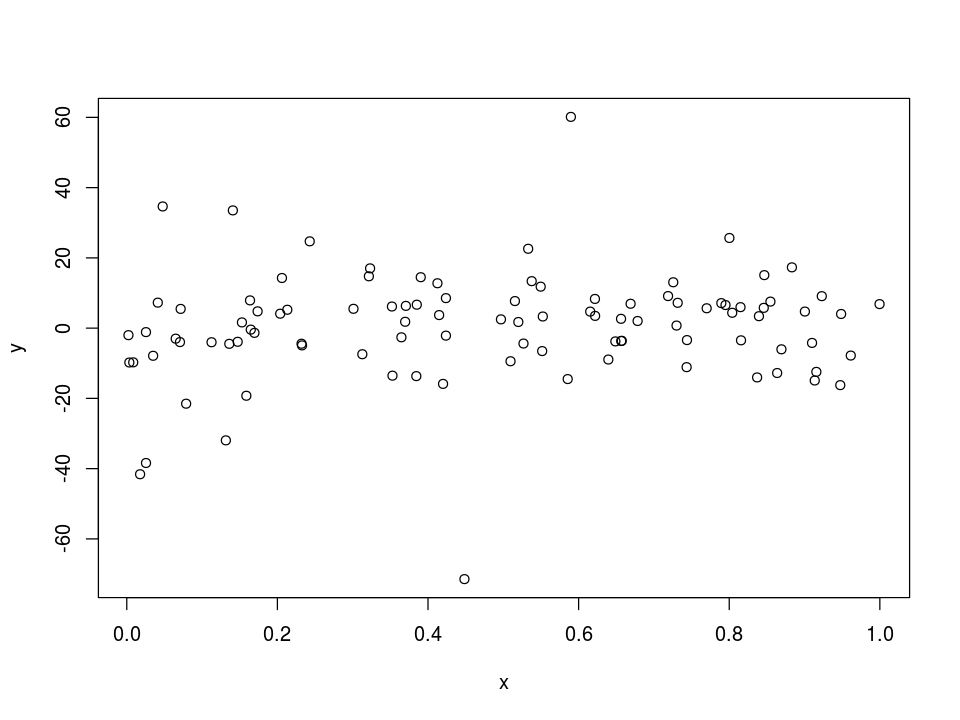

In [3]:
with(xy[1:100, ], plot(x, y))

It's difficult to visually detect the linear relationship because the variance $\sigma^2$ is relatively large.

In [4]:
fit = lm(y ~ x, data = xy)
coef(fit)

(Intercept)           x 
  0.9256451   4.5135066

Since we assumed $\epsilon \sim N(0, \sigma^2)$ we can use a t distribution to calculate exact analytic confidence intervals for the coefficients $\beta_0$ and $\beta_1$. That's what R does here:

In [5]:
confint(fit)

,2.5 %,97.5 %
(Intercept),0.2796422,1.571648
x,3.3922392,5.634774


## Bootstrap

Alternatively, the bootstrap can approximate confidence intervals. The general idea is:
1. Take a sample of size n with replacement of the data
2. Compute the fitted coefficients $\hat{\beta}$.
3. Repeat 1000's of times!

In [6]:
# IMPORTANT: This function takes arguments and does nothing with them.
# And it uses the global variable xy, which MUST be available on the worker machine

# If you think this is weird - you're right!
# We do it here to make something that will easily work in parallel

bootbeta = function(...)
{
    n = nrow(xy)
    xy_boot = xy[sample.int(n, replace = TRUE), ]
    fit_boot = lm(y ~ x, data = xy_boot)
    coef(fit_boot)
}

# Test it!
bootbeta()

(Intercept)           x 
  0.7402433   4.6335976

In [7]:
# We could use replicate()
# doing it this way for consistency with the parallel package
system.time(betas <- lapply(1:1000, bootbeta))

beta_todf = function(betas)
{
    betas = simplify2array(betas)
    row.names(betas) = c("beta0", "beta1")
    betas = data.frame(t(betas)) 
}

betas = beta_todf(betas)

   user  system elapsed 
  8.296   0.000   8.297 

In [8]:
head(betas)

beta0,beta1
1.0345920,3.980326
1.0200276,4.338744
0.6275696,4.863746
0.7279137,4.789514
0.7695179,4.958668
0.3519127,5.788331


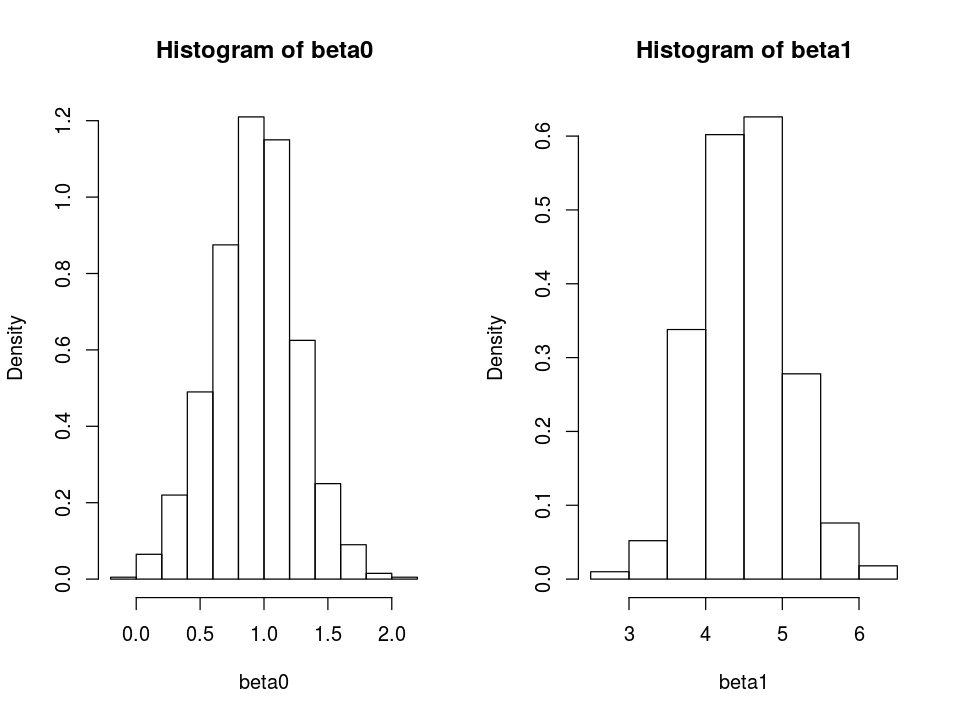

In [9]:
par(mfrow = c(1, 2))
with(betas, hist(beta0, freq = FALSE))
with(betas, hist(beta1, freq = FALSE))

We can take quantiles of the bootstrap statistics to get a 95% confidence interval.

In [10]:
lapply(betas, function(b) quantile(b, probs = c(0.025, 0.975)))

$beta0
     2.5%     97.5% 
0.2608567 1.5561119 

$beta1
    2.5%    97.5% 
3.419527 5.634507

Compare to exact confidence interval from above:

In [11]:
confint(fit)

,2.5 %,97.5 %
(Intercept),0.2796422,1.571648
x,3.3922392,5.634774


# Parallel Time!

What is the embarrassingly parallel problem? Think about it.

In [12]:
library(parallel)

detectCores(logical = FALSE)

[1] 2

`detectCores` is a sanity check. If everything works perfectly then we __may__ see a max speedup of 3.5x for a 4 core machine.

Since I wrote the functions in a nice way above, all I needed to do was change `lapply` to `mclapply`.

Before:
```
system.time(betas <- lapply(1:1000, bootbeta))
```
After:

In [13]:
system.time(betas2 <- mclapply(1:1000, bootbeta))

   user  system elapsed 
  5.124   0.028   5.302 

# MORE SPEED

We do this to accelerate our code. So let's take it a step further and write it in C.

In [24]:
system("R CMD SHLIB bootbetas.c")

In [25]:
dyn.load("bootbetas.so")

In [26]:
out = .C("fit_ols", x, y, n, beta = numeric(2))$beta

In [27]:
# Sanity check: This should be numerically 0
out - coef(fit)

(Intercept)             x 
-1.754152e-14  2.664535e-14